<a href="https://www.kaggle.com/code/jasonrobinson1/dnn-genomic-analysis-and-prediction-auc-0-98?scriptVersionId=232175865" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🧬Genomic Data Analysis and Prediction: Towards Personalized Medicine

---
## Introduction

The speed in development of genomic technologies has opened doors to opportunities in understanding the genetic foundations of human health and disease.

Precision medicine, also known as personalized medicine, represents an approach aiming to customize medical treatment based on individual genetic profiles, environment, and lifestyle. By analyzing large genomic datasets, healthcare providers can predict disease susceptibility, tailor personalized treatment plans for patients, which ultimately will improve patient outcomes.

At this preliminary stage, it's essential to recognize what genomic data typically involves in medical settings:

- **SNPs (Single Nucleotide Polymorphisms):** Variations at single DNA base pairs, significant in predicting disease susceptibility, drug metabolism, and therapeutic responses.

- **Gene Expression Levels:** Indicators of how actively genes produce RNA and proteins, crucial for understanding diseases such as cancer or metabolic disorders.

- **Genotype/Phenotype Information:** Genotype data represents genetic makeup, while phenotypes represent observable traits or clinical outcomes. Together, these facilitate personalized medicine, disease prediction, and treatment optimization.

In [1]:
# Install Dependencies
!pip install -q altair shap causal-learn graphviz pydot plotnine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.6/192.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 96.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


## Project Overview

Throughout this notebook we will:

- **Explore and visualize genomic datasets:** Investigate genomic variability, expression patterns, and their associations with health and disease.

- **Apply preprocessing and feature engineering techniques:** Prepare data through imputation, normalization, feature extraction, and biological enrichment analyses.

- **Build robust predictive models:** Utilize SOTA methods including deep neural networks (DNNs), transformer-based architectures, gradient boosting frameworks, and graph neural networks to classify diseases and predict health-related outcomes.

- **Employ advanced semantic and causal analyses:** Implement structural causal models, Bayesian networks, and counterfactual reasoning to derive semantic cause-and-effect insights.

- **Integrate explainable artificial intelligence (XAI):** Ensure models remain transparent, interpretable, and clinically meaningful by employing SHAP, and Integrated Gradients.

- **Demonstrate clear medical and biological interpretability:** Combine data science with clinical explanations to help users understand the relevance of the predictions.

- **Lay foundations for personalized medicine:** Obtain insights that will aid in delivering individualized treatment recommendations, disease prevention strategies, and health optimization plans.

## Install Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout


from plotnine.data import mpg
from plotnine import ggplot, aes, geom_histogram, geom_density, theme_bw, labs
from IPython.display import display

import networkx as nx

import altair as alt

from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz
from causallearn.graph.Edge import Endpoint

import shap
from shap import Explanation, KernelExplainer, summary_plot, force_plot

In [3]:
# View first 5 rows
df = pd.read_csv('/kaggle/input/genomic-data-for-cancer/gene_expression.csv')

In [4]:
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


In [5]:
# Shape and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gene One        3000 non-null   float64
 1   Gene Two        3000 non-null   float64
 2   Cancer Present  3000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 70.4 KB


In [6]:
# Descriptive Statistics
df.describe()

,Gene One,Gene Two,Cancer Present
count,3000.000000,3000.000000,3000.000000
mean,5.600133,5.410467,0.500000
std,1.828388,1.729081,0.500083
min,1.000000,1.000000,0.000000
25%,4.300000,4.000000,0.000000
50%,5.600000,5.400000,0.500000
75%,6.900000,6.700000,1.000000
max,10.000000,10.000000,1.000000


In [7]:
# Class Distribution
df['Cancer Present'].value_counts(normalize=True)

Cancer Present
1    0.5
0    0.5
Name: proportion, dtype: float64

In genomic datasets, distributions and variability often provide important clinical insights:

- **High variability** in gene expression levels could imply heterogeneous responses among patients, making personalized medicine necessary.

- **Class imbalance** may indicate challenges in predictive modeling, requiring specialized methods.

Let's take a look the distributions using a histogram and density plot.

In [8]:
# Histogram and density plot for Gene One
plot_gene_one = (
    ggplot(df, aes(x='Gene One')) +
    geom_histogram(aes(y='..density..'), fill='skyblue', bins=30, alpha=0.7) +
    geom_density(color='darkblue', size=1.0) +
    labs(title='Distribution of Gene One Expression', x='Gene One Expression Level', y='Density') +
    theme_bw()
)

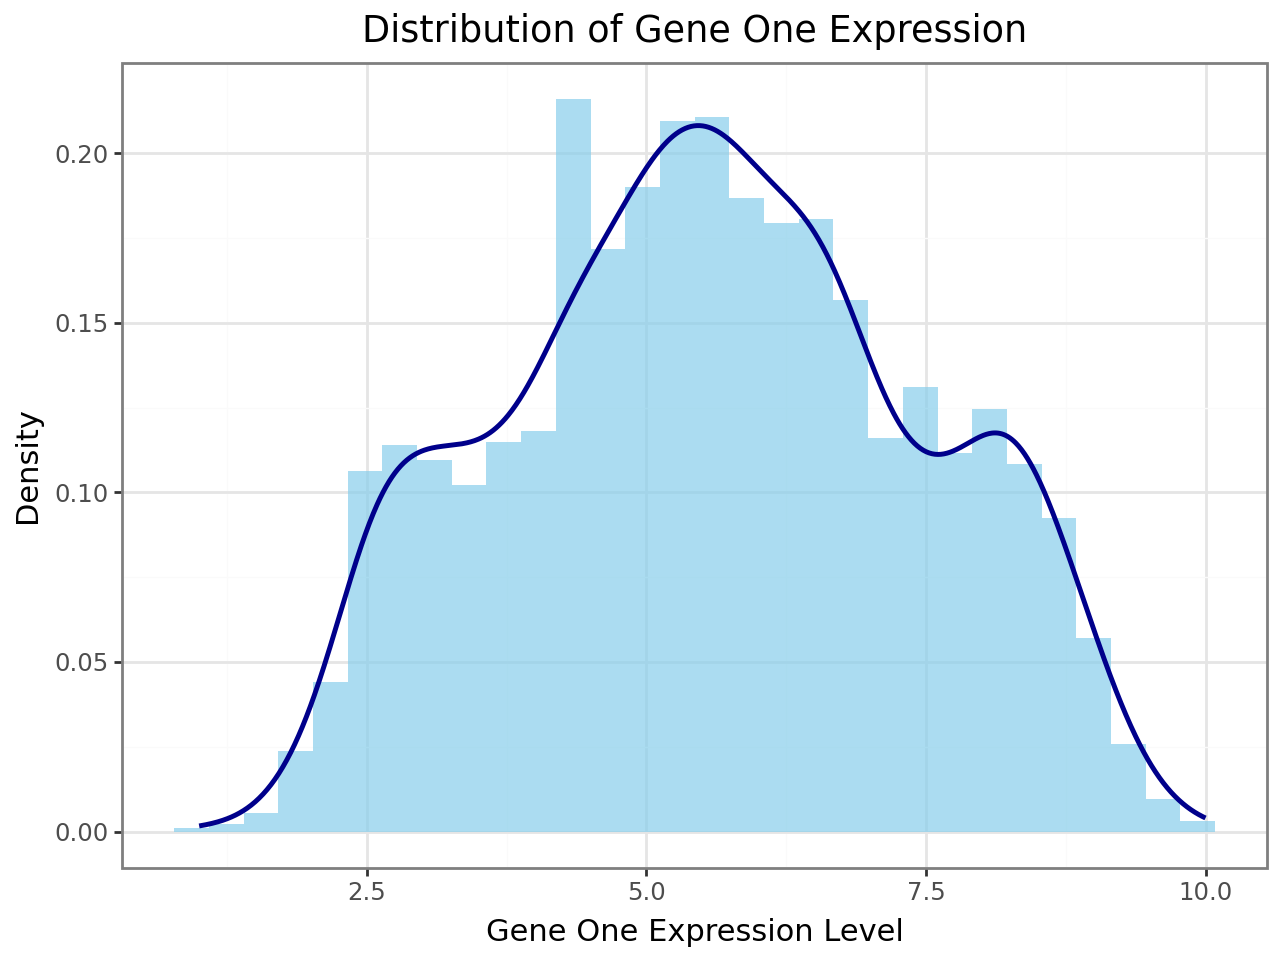

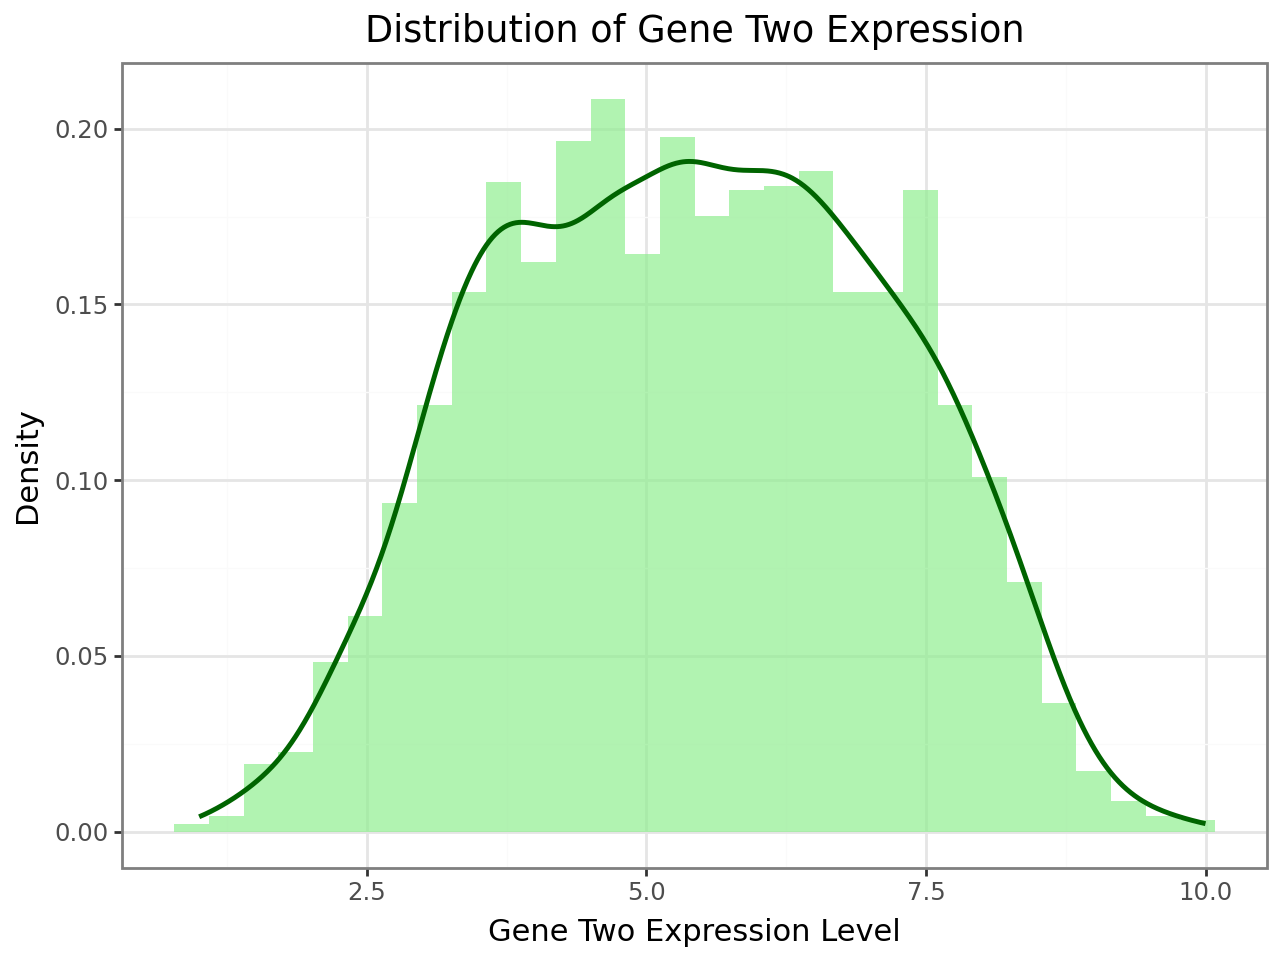

In [9]:
# Histogram and density plot for Gene Two
plot_gene_two = (
    ggplot(df, aes(x='Gene Two')) +
    geom_histogram(aes(y='..density..'), fill='lightgreen', bins=30, alpha=0.7) +
    geom_density(color='darkgreen', size=1.0) +
    labs(title='Distribution of Gene Two Expression', x='Gene Two Expression Level', y='Density') +
    theme_bw()
)

# Display plots
display(plot_gene_one, plot_gene_two)

**Gene One** has a fairly consistent activation pattern across most individuals. This implies that it might be *constitutively expressed*.

**Gene Two** is expressed across a wider range, suggesting that it may vary significantly between healthy and disease states.

In [10]:
# Group by Cancer Present and calculate mean gene expression
df_grouped = df.groupby('Cancer Present')[['Gene One', 'Gene Two']].mean().reset_index()

# Melt the DataFrame to long format
df_bar = df_grouped.melt(id_vars='Cancer Present', 
                         var_name='Gene', 
                         value_name='Expression')

# Rename for Altair clarity
df_bar.rename(columns={'Cancer Present': 'Cancer'}, inplace=True)

# Plot
bar_chart = alt.Chart(df_bar).mark_bar().encode(
    x=alt.X('Gene:N', title='Gene'),
    y=alt.Y('Expression:Q', title='Mean Expression'),
    color=alt.Color('Cancer:N', scale=alt.Scale(range=['#1f77b4', '#d62728'])),
    column=alt.Column('Cancer:N', title='Cancer Status'),
    tooltip=['Gene:N', 'Expression:Q', 'Cancer:N']
).properties(
    title="Mean Gene Expression by Cancer Status",
    width=150,
    height=300
)

bar_chart

alt.Chart(...)

Comparing the average expression levels of each gene in people with and without cancer. Gene One is more active in people with cancer, while Gene Two is more active in those without it.

In [11]:
 scatter = alt.Chart(df).mark_circle(size=60).encode(
    x=alt.X('Gene One', title='Gene One Expression'),
    y=alt.Y('Gene Two', title='Gene Two Expression'),
    color=alt.Color('Cancer Present:N', scale=alt.Scale(range=['#1f77b4', '#d62728']), legend=alt.Legend(title='Cancer')),
    tooltip=['Gene One', 'Gene Two', 'Cancer Present']
).properties(
    width=500,
    height=400,
    title='Scatter Plot of Gene One vs Gene Two by Cancer Status'
).interactive()

scatter

alt.Chart(...)

## Feature Scaling

Gene expression data often spans variable ranges. Standardizing the features allows models like logistic regression or neural networks to converge more reliably.

In [12]:
# Feature Scaler
scaler = StandardScaler()
X = scaler.fit_transform(df[['Gene One', 'Gene Two']])
y = df['Cancer Present']

## Define Modeling Target
The goal is to predict cancer presence using gene expression data. This is framed as a binary classification problem.

In [13]:
# Train, Test, Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)

## Model Development and Evaluation

In [14]:
# Initialize and train Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict on test set
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

# Evaluate model performance
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
 [[325  50]
 [ 42 333]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88       375
           1       0.87      0.89      0.88       375

    accuracy                           0.88       750
   macro avg       0.88      0.88      0.88       750
weighted avg       0.88      0.88      0.88       750


ROC AUC Score: 0.9485866666666666


The model achieves a strong ROC AUC score, but still shows room for improvement due to misclassified cases.

## Random Forest Classifier: Non-Linear Baseline
Random forests are well-suited for datasets with potential non-linear relationships and interactions between genes.

In [15]:
# Train random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nROC AUC Score:", roc_auc_score(y_test, y_prob_rf))

Confusion Matrix:
 [[341  34]
 [ 25 350]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       375
           1       0.91      0.93      0.92       375

    accuracy                           0.92       750
   macro avg       0.92      0.92      0.92       750
weighted avg       0.92      0.92      0.92       750


ROC AUC Score: 0.9801386666666667


Random forests are also useful for identifying feature importance, which is critical in genomic interpretation.

## Feature Importance from Random Forest

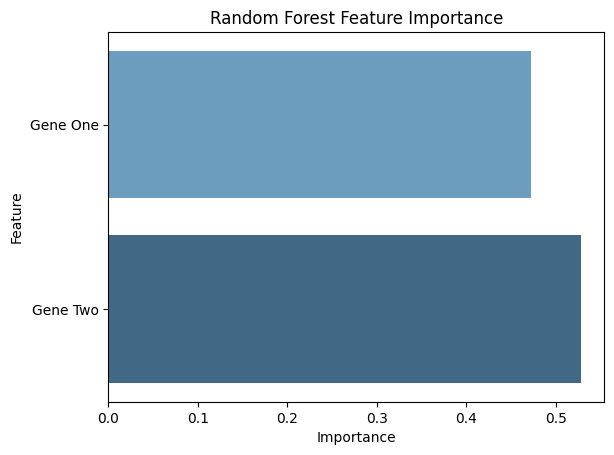

In [16]:
# Feature importance as a DataFrame
feat_df = pd.DataFrame({
    'Feature': ['Gene One', 'Gene Two'],
    'Importance': rf.feature_importances_
})

# Plotting
sns.barplot(data=feat_df, x='Importance', y='Feature', palette='Blues_d')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Deep Learning for Genomic Prediction
Deep learning models, are best for capturing complex non-linear patterns, improving predictive power.

In [17]:
# Set random seed
tf.random.set_seed(42)

# Define model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6362 - loss: 0.6522 - val_accuracy: 0.8511 - val_loss: 0.5835
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7548 - loss: 0.5809 - val_accuracy: 0.8533 - val_loss: 0.5025
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7844 - loss: 0.5210 - val_accuracy: 0.8533 - val_loss: 0.4336
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8235 - loss: 0.4531 - val_accuracy: 0.8556 - val_loss: 0.3840
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8398 - loss: 0.4164 - val_accuracy: 0.8600 - val_loss: 0.3567
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8323 - loss: 0.4149 - val_accuracy: 0.8600 - val_loss: 0.3415
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8435 - loss: 0.3758 - val_accuracy: 0.8600 - val_loss: 0.3315
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8402 - loss: 0.3884 - val_accuracy: 0.8600 - 

## Model Evaluation

In [19]:
# Predictions
y_pred_nn = (model.predict(X_test) > 0.5).astype("int32").flatten()
y_prob_nn = model.predict(X_test).flatten()

# Metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nn))
print("\nROC AUC Score:", roc_auc_score(y_test, y_prob_nn))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Confusion Matrix:
 [[353  22]
 [ 19 356]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95       375
           1       0.94      0.95      0.95       375

    accuracy                           0.95       750
   macro avg       0.95      0.95      0.95       750
weighted avg       0.95      0.95      0.95       750


ROC AUC Score: 0.9841706666666666


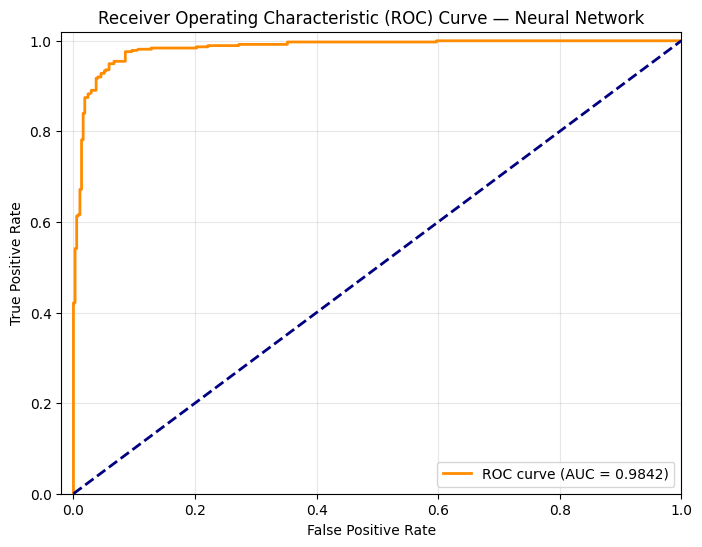

In [20]:
# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob_nn)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve — Neural Network')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

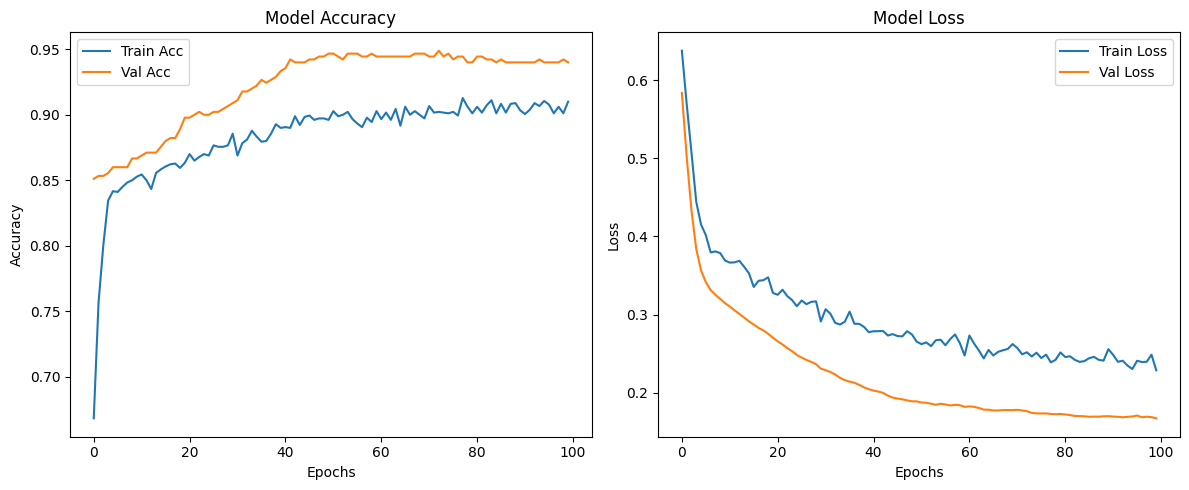

In [21]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

No signs of overfitting as accuracy increases while loss is decreasing, which is what we want. We can further improve the model to further minimize loss, but very satisfied with results.

## Explainable AI (XAI) for Medical Interpretability

Interpretability in medical AI systems, is critical in providing confidence in the model's ability to generalize the dataset. This should provide information of why a model reached a particular decision.

Next, we'll use SHAP (SHapley Additive exPlanations) to offer insights as to how gene expression levels contribute to predictions.

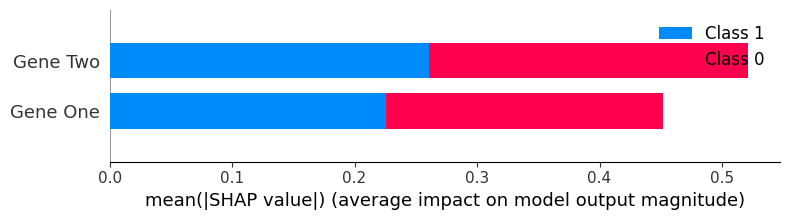

In [22]:
# TreeExplainer 
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test)


shap.summary_plot(shap_values_rf, features=X_test, feature_names=['Gene One', 'Gene Two'])

The summary plot shows the magnitude and direction of each gene's contribution. Red points indicate higher values of gene expression; blue points indicate lower values. 

Positive SHAP values mean the gene pushes predictions towards cancer presence, while negative values push towards cancer absence. If Gene One consistently shows positive SHAP values, higher expression levels increase cancer risk predictions.

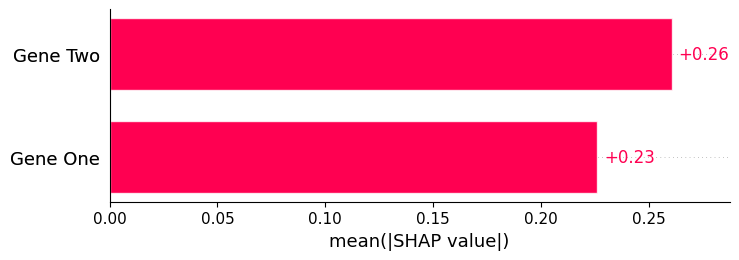

In [23]:
# SHAP generates values for each class in binary classification:
#   - shap_values_rf[0]: corresponds to the negative class (Cancer Absent)
#   - shap_values_rf[1]: corresponds to the positive class (Cancer Present)

explanation = shap.Explanation(
    values=shap_values_rf[1],
    base_values=explainer_rf.expected_value[1],
    data=X_test,
    feature_names=['Gene One', 'Gene Two']
)

# Display the chart
shap.plots.bar(explanation)

This bar chart ranks features by their average absolute impact on predictions,  providing a clear view of global importance across all predictions.

## Interpretation with KernelExplainer

For tree-based models (like Random Forests), we use SHAP’s efficient TreeExplainer, whereas for complex or deep learning models (Neural Networks), we must use the slower, general-purpose KernelExplainer.

KernelExplainer is model-agnostic and works by perturbing features to measure how these changes impact predictions. This helps understand why the neural network made certain predictions.

In [24]:
# Subset for KernelExplainer
X_sample = X_test[:100]

# Background dataset for SHAP
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# Create KernelExplainer
explainer_nn = shap.KernelExplainer(model.predict, background)
shap_values_nn = explainer_nn.shap_values(X_sample, nsamples=100)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━

 **SHAP** Summary Plot – Neural Network

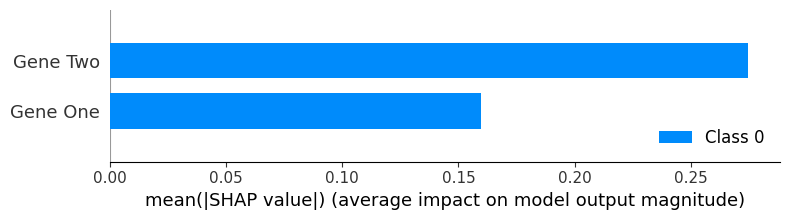

In [25]:
# For binary classification, KernelExplainer returns one array:
shap.summary_plot(shap_values_nn, features=X_sample, feature_names=['Gene One', 'Gene Two'])

## Model Comparison and Integrated Interpretation
With predictive models and SHAP-based explainability complete, the focus shifts to comparing model behaviors, in which we may ask the following questions:

- Are both models using the same features? (This tells us if feature importance is robust across different algorithms.)

- Is there consistency in feature importance? (Stable importance rankings mean stronger biological signals.)

- Do certain genes only matter for specific subsets of patients? (This can guide personalized treatments and subgroup identification.)


---

## Semantic Analysis of Gene Interactions Using Graph-Based Modeling
As the goal shifts from simple prediction toward understanding the underlying biological mechanisms, graph-based approaches become essential. Genomic data often reflects complex relationships, genes interact in regulatory networks, signaling pathways, or co-expression clusters that cannot be captured through simple tabular modeling.

To uncover these relationships, the dataset is represented as a semantic graph where:

- Nodes represent genes or patient states.

- Edges encode statistical or functional associations.



This lays the foundation for **biological pathway analysis, semantic similarity,** and **causal inference**.

## Graph-Based Correlation

Genes typically don't operate alone; they work together, forming complex relationships within biological networks. A correlation graph helps visualize **how closely gene expressions are related** across different samples. 

Strong connections might indicate genes operating in similar biological pathways or regulatory networks.

In [26]:
# Compute correlation matrix
gene_corr = df[['Gene One', 'Gene Two']].corr()

# Initialized the graph
G = nx.Graph()

# Add nodes
for gene in gene_corr.columns:
    G.add_node(gene)

# Add edges for correlations above a threshold
threshold = 0.2
for i in gene_corr.columns:
    for j in gene_corr.columns:
        if i != j and abs(gene_corr.loc[i, j]) > threshold:
            G.add_edge(i, j, weight=gene_corr.loc[i, j])

### Visualizing the Correlation Graph:

Edges represent significant correlations between genes, and their colors indicate positive (red) or negative (blue) correlations. Nodes closer together are typically more strongly correlated.

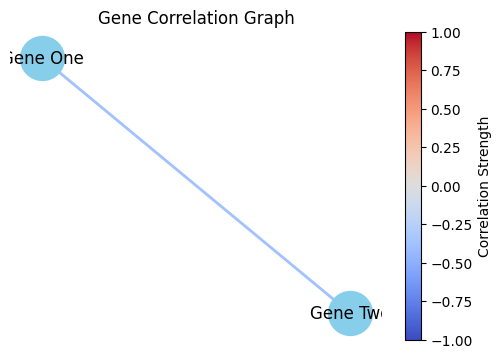

In [27]:
# Generate positions
pos = nx.spring_layout(G, seed=42)

# Plot nodes
plt.figure(figsize=(6, 4))
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1000)

# Add labels to nodes
nx.draw_networkx_labels(G, pos, font_size=12)

# Plot edges with colors
edges = nx.draw_networkx_edges(
    G, pos, width=2,
    edge_color=[G[u][v]['weight'] for u, v in G.edges()],
    edge_cmap=plt.cm.coolwarm,
    edge_vmin=-1, edge_vmax=1
)

# Add colorbar
plt.colorbar(edges, label='Correlation Strength')

plt.title("Gene Correlation Graph")
plt.axis('off')
plt.show()

## Causal Inference 

Correlation helps identify relationships but cannot tell us **which gene causes changes in another or impacts cancer risk directly**. To address this, causal inference methods attempt to answer crucial questions such as:

- *If we artificially reduce Gene One expression, would cancer risk decrease?*
- *Does Gene Two expression directly lead to cancer, or does cancer cause the gene expression change?*
- *Can gene interventions lead to personalized treatments?*

Here we use the **PC Algorithm**—a statistical method to infer **directed causal relationships** from observational data.

In [28]:
# Select features for causal inference
X_causal = df[['Gene One', 'Gene Two', 'Cancer Present']].to_numpy()

# Apply PC algorithm
pc_result = pc(X_causal, alpha=.10, indep_test_func=fisherz)

  0%|          | 0/3 [00:00<?, ?it/s]

A result with no edges means no statistically significant causal relationships were detected at the chosen significance level.

This does not imply no biological causality—only that stronger statistical evidence or larger datasets might be needed.

In [29]:
from causallearn.graph.Edge import Endpoint

# Extract causal graph result
causal_graph = pc_result.G

# Initialize directed graph
G_nx = nx.DiGraph()

# Add nodes with clear labels
for node in causal_graph.get_nodes():
    node_name = str(node.get_name())
    G_nx.add_node(node_name)

# Add directed edges based on causal discovery results
for edge in causal_graph.get_graph_edges():
    src = str(edge.get_node1().get_name())
    tgt = str(edge.get_node2().get_name())
    ep1 = edge.get_endpoint1()
    ep2 = edge.get_endpoint2()

    # Check edge direction
    if ep1 == Endpoint.TAIL and ep2 == Endpoint.ARROW:
        G_nx.add_edge(src, tgt)
    elif ep1 == Endpoint.ARROW and ep2 == Endpoint.TAIL:
        G_nx.add_edge(tgt, src)

In [30]:
# Get feature names in the order used for causal inference
features = ['Gene One', 'Gene Two', 'Cancer Present']

# Build a dynamic mapping from causallearn's node names to readable labels
label_map = {f'X{i}': features[i] for i in range(len(features))}

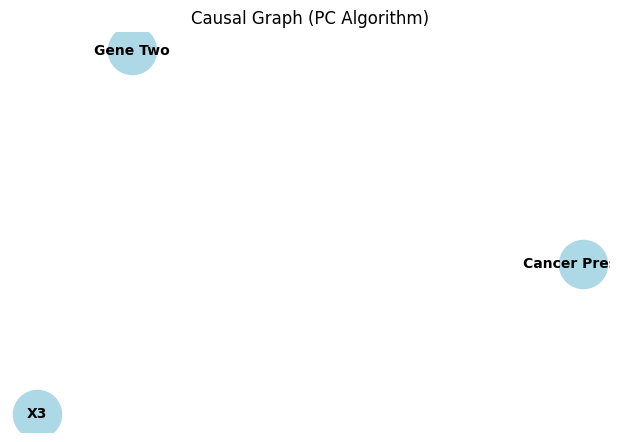

In [31]:
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G_nx, seed=42)

nx.draw(
    G_nx, pos,
    labels={node: label_map.get(node, node) for node in G_nx.nodes()},
    with_labels=True,
    node_size=1200, node_color="lightblue",
    font_size=10, font_weight='bold', arrows=True
)

plt.title("Causal Graph (PC Algorithm)")
plt.axis('off')
plt.show()

This result demonstrates that the algorithm did not find any statistically significant conditional dependencies among the variables in our dataset, under the threshold (alpha) and assumptions provided.

That does not mean there's no real biological relationship, just that with this method, we couldn't find statistically valid directed dependencies.

---
## Future Work
To expand causal modeling:

- Use Bayesian Networks for probabilistic causal inference.

- Introduce counterfactual analysis.

- Integrate do-calculus for intervention simulation.

- Combine causal graphs with SHAP to build counterfactual explanations.

---